In [14]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



In [15]:
data_path = 'covid_19_clean_complete.csv'
df = pd.read_csv(data_path)

In [16]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  14664 non-null  object 
 1   Country/Region  49068 non-null  object 
 2   Lat             49068 non-null  float64
 3   Long            49068 non-null  float64
 4   Date            49068 non-null  object 
 5   Confirmed       49068 non-null  int64  
 6   Deaths          49068 non-null  int64  
 7   Recovered       49068 non-null  int64  
 8   Active          49068 non-null  int64  
 9   WHO Region      49068 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 3.7+ MB
None
Province/State    34404
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
Active                0
WHO Region            0
dtype: int64


In [17]:

country_data = df.groupby('Country/Region')['Confirmed'].sum().reset_index()

country_data = country_data.sort_values(by='Confirmed', ascending=False)

fig = px.bar(country_data, x='Country/Region', y='Confirmed', 
             title='Overall Confirmed COVID-19 Cases by Country', 
             labels={'Country/Region': 'Country/Region', 'Confirmed': 'Confirmed Cases'},
             color='Confirmed',
             color_continuous_scale=px.colors.sequential.Blues)

fig.update_layout(xaxis_tickangle=-90, xaxis={'categoryorder':'total descending'})

fig.show()

In [18]:
country_data = df.groupby('Country/Region')['Deaths'].sum().reset_index()

country_data = country_data.sort_values(by='Deaths', ascending=False)

fig = px.bar(country_data, x='Country/Region', y='Deaths', 
             title='Overall COVID-19 Death Cases by Country', 
             labels={'Country/Region': 'Country/Region', 'Deaths': 'Death Cases'},
             color='Deaths',
             color_continuous_scale=px.colors.sequential.Reds)

fig.update_layout(xaxis_tickangle=-90, xaxis={'categoryorder':'total descending'})

fig.show()

In [19]:
country_data = df.groupby('Country/Region')['Recovered'].sum().reset_index()

country_data = country_data.sort_values(by='Recovered', ascending=False)

fig = px.bar(country_data, x='Country/Region', y='Recovered', 
             title='Overall COVID-19 Recovery Cases by Country', 
             labels={'Country/Region': 'Country/Region', 'Recovered': 'Recovered Cases'},
             color='Recovered',
             color_continuous_scale=px.colors.sequential.Greens)

fig.update_layout(xaxis_tickangle=-90, xaxis={'categoryorder':'total descending'})

fig.show()

In [20]:

india_data = df[df['Country/Region'] == 'India']

india_data = india_data.groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

india_data['Active'] = india_data['Confirmed'] - india_data['Deaths'] - india_data['Recovered']
india_data['Death Percentage'] = (india_data['Deaths'] / india_data['Confirmed']) * 100
india_data['Recovered Percentage'] = (india_data['Recovered'] / india_data['Confirmed']) * 100
india_data['Active Percentage'] = (india_data['Active'] / india_data['Confirmed']) * 100

india_data_melted = india_data.melt(id_vars='Date', value_vars=['Death Percentage', 'Recovered Percentage', 'Active Percentage'],
                                    var_name='Status', value_name='Percentage')

fig = px.line(india_data_melted, x='Date', y='Percentage', color='Status',
              title='COVID-19 Confirmed, Death, and Recovery Percentages in India',
              labels={'Date': 'Date', 'Percentage': 'Percentage'})

fig.update_layout(xaxis_tickangle=-90)

fig.show()

In [21]:

india_data = df[df['Country/Region'] == 'India']

total_confirmed = india_data['Confirmed'].sum()
total_deaths = india_data['Deaths'].sum()
total_recovered = india_data['Recovered'].sum()
total_active = total_confirmed - total_deaths - total_recovered

death_percentage = (total_deaths / total_confirmed) * 100
recovered_percentage = (total_recovered / total_confirmed) * 100
active_percentage = (total_active / total_confirmed) * 100

labels = ['Deaths', 'Recovered', 'Active']
values = [death_percentage, recovered_percentage, active_percentage]

fig = px.pie(values=values, names=labels, title='COVID-19 Confirmed, Death, Recovery, and Active Percentages in India',
             color_discrete_sequence=px.colors.sequential.RdBu)

fig.show()

In [22]:
df['Province/State'] = df['Province/State'].fillna('Unknown')
df[['Confirmed', 'Deaths', 'Recovered', 'Active']] = df[['Confirmed', 'Deaths', 'Recovered', 'Active']].fillna(0)
df['Date'] = pd.to_datetime(df['Date'])

In [23]:
label_encoder = LabelEncoder()
df['WHO_Region_encoded'] = label_encoder.fit_transform(df['WHO Region'])
df['Country_Region_encoded'] = label_encoder.fit_transform(df['Country/Region'])

df['Mortality_Rate'] = df['Deaths'] / df['Confirmed']
df['Recovery_Rate'] = df['Recovered'] / df['Confirmed']
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [24]:
X = df[['Lat', 'Long', 'Confirmed', 'Deaths', 'Recovered', 'WHO_Region_encoded', 'Country_Region_encoded', 'Mortality_Rate', 'Recovery_Rate']]
y = df['Active']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R2 Score: {r2}')
    return y_pred

# 6.1 Linear Regression
print("Linear Regression:")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = evaluate_model(lr_model, X_test_scaled, y_test)

# 6.2 Decision Tree Regressor
print("\nDecision Tree Regressor:")
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = evaluate_model(dt_model, X_test_scaled, y_test)

# 6.3 Random Forest Regressor
print("\nRandom Forest Regressor:")
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = evaluate_model(rf_model, X_test_scaled, y_test)

# 6.4 Support Vector Regressor
print("\nSupport Vector Regressor:")
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = evaluate_model(svr_model, X_test_scaled, y_test)

# 6.5 K-Nearest Neighbors Regressor
print("\nK-Nearest Neighbors Regressor:")
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = evaluate_model(knn_model, X_test_scaled, y_test)

# 6.6 Neural Network
print("\nNeural Network:")
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
history = nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
nn_loss, nn_mse = nn_model.evaluate(X_test_scaled, y_test)
print(f'Neural Network Mean Squared Error: {nn_mse}')
y_pred_nn = nn_model.predict(X_test_scaled)


Linear Regression:
Mean Squared Error: 2.8155244806979266e-21
R2 Score: 1.0

Decision Tree Regressor:
Mean Squared Error: 6357289.9799266355
R2 Score: 0.9991529043379657

Random Forest Regressor:
Mean Squared Error: 3160418.055403037
R2 Score: 0.9995788808700876

Support Vector Regressor:
Mean Squared Error: 7576633030.585236
R2 Score: -0.009570586413505167

K-Nearest Neighbors Regressor:
Mean Squared Error: 4662746.414322393
R2 Score: 0.9993786987421982

Neural Network:
Epoch 1/50
982/982 [==============================] - 11s 8ms/step - loss: 4684674560.0000 - mean_squared_error: 4684674560.0000 - val_loss: 2836003584.0000 - val_mean_squared_error: 2836003584.0000
Epoch 2/50
982/982 [==============================] - 8s 8ms/step - loss: 1491482112.0000 - mean_squared_error: 1491482112.0000 - val_loss: 959461952.0000 - val_mean_squared_error: 959461952.0000
Epoch 3/50
982/982 [==============================] - 7s 8ms/step - loss: 868646656.0000 - mean_squared_error: 868646656.0000 - v

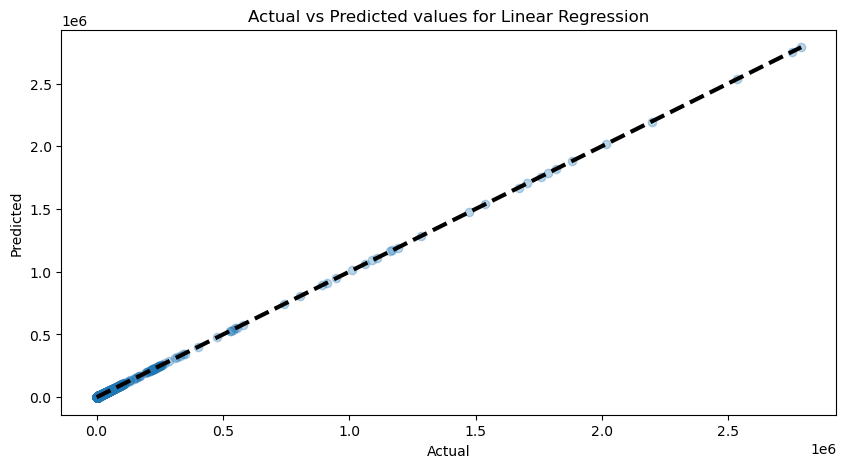

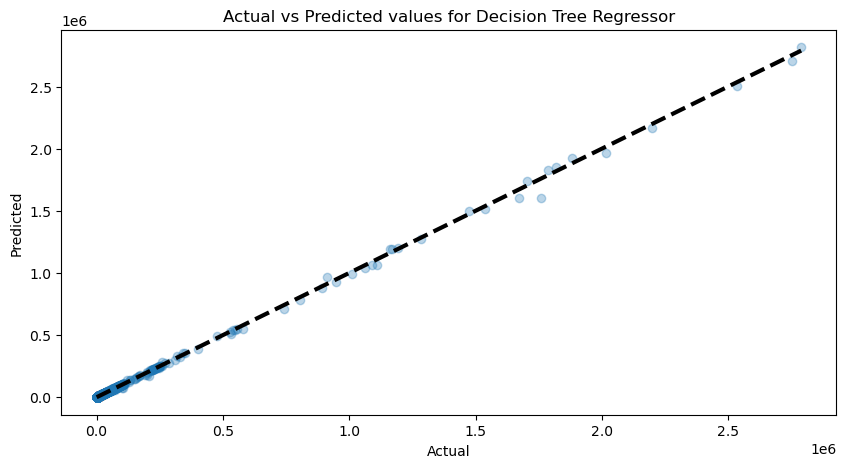

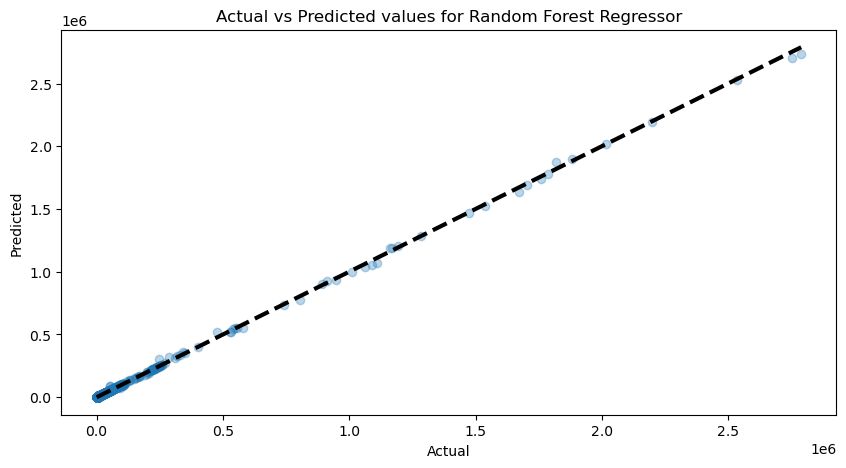

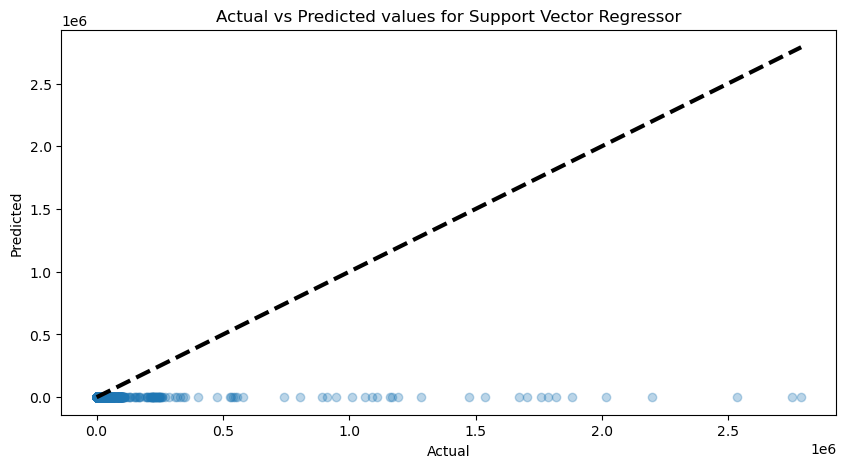

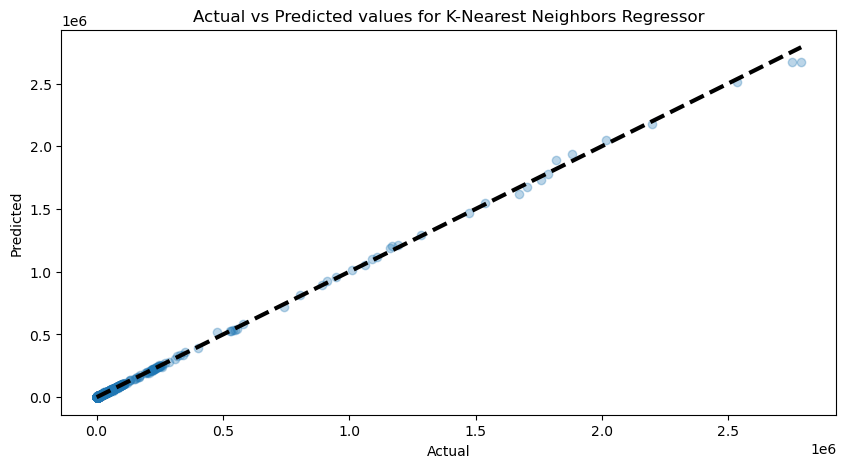

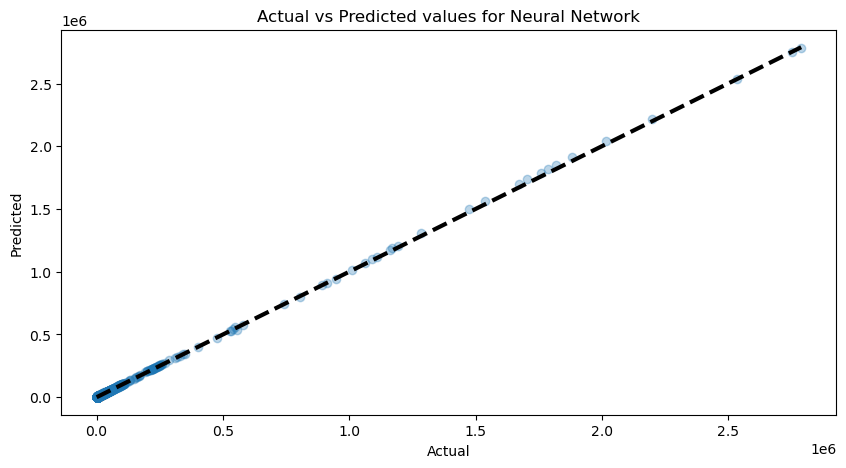

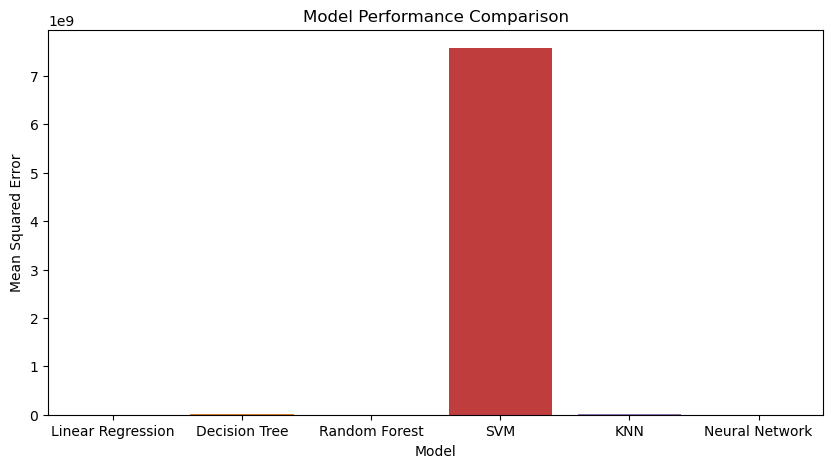

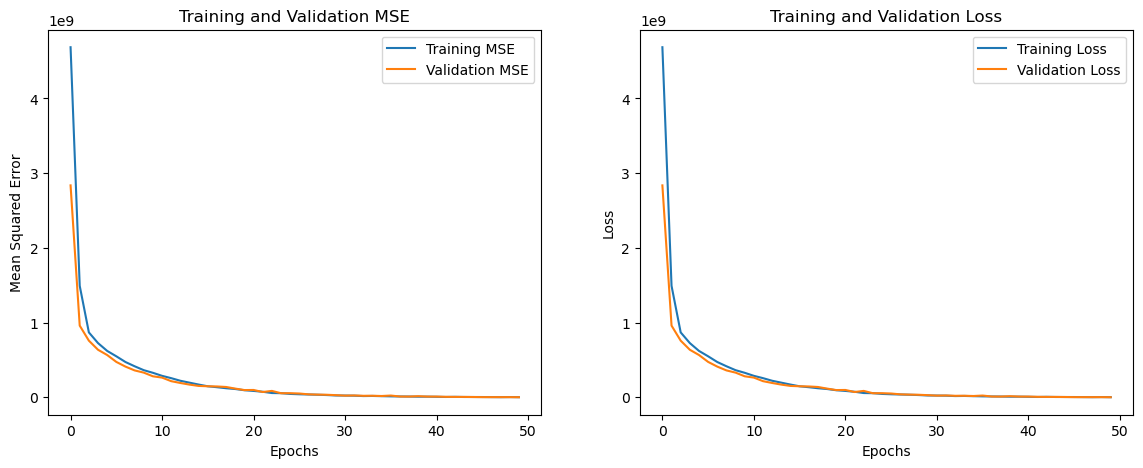

In [26]:

def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted values for {model_name}')
    plt.show()

def plot_model_performance(models, mse_scores):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=models, y=mse_scores)
    plt.xlabel('Model')
    plt.ylabel('Mean Squared Error')
    plt.title('Model Performance Comparison')
    plt.show()

def plot_learning_curves(history):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mean_squared_error'], label='Training MSE')
    plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('Training and Validation MSE')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_actual_vs_predicted(y_test, y_pred_lr, "Linear Regression")
plot_actual_vs_predicted(y_test, y_pred_dt, "Decision Tree Regressor")
plot_actual_vs_predicted(y_test, y_pred_rf, "Random Forest Regressor")
plot_actual_vs_predicted(y_test, y_pred_svr, "Support Vector Regressor")
plot_actual_vs_predicted(y_test, y_pred_knn, "K-Nearest Neighbors Regressor")
plot_actual_vs_predicted(y_test, y_pred_nn, "Neural Network")

models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'SVM', 'KNN', 'Neural Network']
mse_scores = [
    mean_squared_error(y_test, y_pred_lr),
    mean_squared_error(y_test, y_pred_dt),
    mean_squared_error(y_test, y_pred_rf),
    mean_squared_error(y_test, y_pred_svr),
    mean_squared_error(y_test, y_pred_knn),
    nn_mse
]
plot_model_performance(models, mse_scores)
plot_learning_curves(history)
